# Load libraries

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import rcParams
from matplotlib import cm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [20]:
#train = pd.read_csv('/home/ashioyajotham/NextGen/Train.csv')
train = pd.read_csv('/kaggle/input/nextgen-data/NextGen/Train.csv')

In [21]:
train.head()

,Unnamed: 0,AP1,AP2,AP3,AP4,AP5,AP6,AP7,AP8,AP9,TP1,TP2,TP3,TP4,TP5,TP6,TP7,TP8,TP9,Deployment
0,STA1,-64.87,-75.67,-85.98,-68.34,-77.09,-86.38,-83.07,-85.13,-89.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9391
1,STA2,-79.89,-67.19,-75.01,-79.89,-67.19,-75.01,-85.82,-82.19,-83.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9391
2,STA3,-87.19,-77.41,-55.58,-88.46,-81.24,-74.39,-91.72,-87.85,-85.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9391
3,STA4,-81.35,-82.71,-87.90,-66.55,-72.62,-84.37,-69.83,-74.66,-84.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9391
4,STA5,-85.33,-82.09,-84.40,-78.77,-66.72,-76.34,-78.77,-66.72,-76.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9391


In [22]:
test = pd.read_csv('/kaggle/input/nextgen-data/NextGen/Train.csv')
train_target = pd.read_csv('/kaggle/input/nextgen-data/NextGen/TrainTargets.csv')
sample_submission = pd.read_csv('/kaggle/input/nextgen-data/NextGen/TrainTargets.csv')

In [23]:
train_target.head()

,ID,Target
0,Deployment10000_TXOP100_AP3_STA9,108.0
1,Deployment10000_TXOP100_AP4_STA13,348.0
2,Deployment10000_TXOP100_AP9_STA36,210.0
3,Deployment10000_TXOP10_AP3_STA11,156.0
4,Deployment10000_TXOP10_AP7_STA25,0.0


In [24]:
test.head()

,Unnamed: 0,AP1,AP2,AP3,AP4,AP5,AP6,AP7,AP8,AP9,TP1,TP2,TP3,TP4,TP5,TP6,TP7,TP8,TP9,Deployment
0,STA1,-64.87,-75.67,-85.98,-68.34,-77.09,-86.38,-83.07,-85.13,-89.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9391
1,STA2,-79.89,-67.19,-75.01,-79.89,-67.19,-75.01,-85.82,-82.19,-83.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9391
2,STA3,-87.19,-77.41,-55.58,-88.46,-81.24,-74.39,-91.72,-87.85,-85.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9391
3,STA4,-81.35,-82.71,-87.90,-66.55,-72.62,-84.37,-69.83,-74.66,-84.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9391
4,STA5,-85.33,-82.09,-84.40,-78.77,-66.72,-76.34,-78.77,-66.72,-76.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9391


* Our data is WIFI connection data with the task of predicting the throughput of the connection.
* We will use a simple neural network to predict the throughput of the connection.

*** Variables ***
* AP: Access point
* Deployment: Deployment
* STA: Station
* TP: Throughput 


*** Data ***
* The data is from the UCI Machine Learning Repository

In [25]:
def preprocess(data,is_train=True): # is_train is a boolean variable to check if the data is train or test

  dep=data['Deployment'].unique() # get the unique deployment values
  rows=[] # create an empty list to store the rows
  for dd in dep: # iterate through the deployment values
    df=data[data.Deployment==dd] # get the data for each deployment
    
    toxp_map=dict() # create a dictionary to store the txop values
    rssi_map=dict() # create a dictionary to store the rssi values
    flag=0 # create a flag variable to check if the data is for the first deployment
    for i, j in df.iterrows(): # iterate through the data
        if('STA' in j[0]): 
          rssi_map[j[0]]={f'AP{i}':j[i] for i in range(1,10)} # store the rssi values in the rssi_map dictionary
        else:
          toxp_map[j[0]]={(j.index[i],'STA'+str(int(j[i]))) for i in range(1,10)} # store the txop values in the toxp_map dictionary

    
    for exp,elems in toxp_map.items(): # iterate through the txop values
      rows1=[]
      for e in elems: # iterate through the elements in the txop values
        row=[dd,exp] # create a row with the deployment and txop values
        if(e[-1]!='STA0'): # check if the STA is not 0
          row.extend([e[0],e[1],rssi_map[e[-1]][e[0]]]) # append the AP, STA and RSSI values to the row
          rows.append(row) # append the row to the rows list
  

      #rows.extend(rows1)
    
  data=pd.DataFrame(rows) # create a dataframe from the rows list
  data.columns = ['Deployment','TXOP','mainAP','mainSTA','mainRSSI'] # rename the columns
  data['ID']='Deployment'+data['Deployment'].astype(str)+'_'+data['TXOP']+'_'+data['mainAP']+'_'+data['mainSTA']
  if(is_train):
    tt=pd.read_csv('/kaggle/input/nextgen-data/NextGen/TrainTargets.csv')
    data=pd.merge(data,tt,on='ID')
  
  
  return data

train=preprocess(train)
test=preprocess(test,False) 

In [26]:
test.head()

,Deployment,TXOP,mainAP,mainSTA,mainRSSI,ID
0,9391,TXOP1,AP1,STA1,-64.87,Deployment9391_TXOP1_AP1_STA1
1,9391,TXOP1,AP2,STA2,-67.19,Deployment9391_TXOP1_AP2_STA2
2,9391,TXOP1,AP5,STA5,-66.72,Deployment9391_TXOP1_AP5_STA5
3,9391,TXOP1,AP7,STA7,-63.71,Deployment9391_TXOP1_AP7_STA7
4,9391,TXOP2,AP1,STA1,-64.87,Deployment9391_TXOP2_AP1_STA1


In [27]:
train.head()

,Deployment,TXOP,mainAP,mainSTA,mainRSSI,ID,Target
0,9391,TXOP1,AP1,STA1,-64.87,Deployment9391_TXOP1_AP1_STA1,30.0
1,9391,TXOP1,AP2,STA2,-67.19,Deployment9391_TXOP1_AP2_STA2,0.0
2,9391,TXOP1,AP5,STA5,-66.72,Deployment9391_TXOP1_AP5_STA5,54.0
3,9391,TXOP1,AP7,STA7,-63.71,Deployment9391_TXOP1_AP7_STA7,108.0
4,9391,TXOP2,AP1,STA1,-64.87,Deployment9391_TXOP2_AP1_STA1,54.0


# Modelling
* The baseline is a linear regression model
* We will use a simple neural network to predict the throughput of the connection.

In [28]:
train.isna().sum()

Deployment    0
TXOP          0
mainAP        0
mainSTA       0
mainRSSI      0
ID            0
Target        0
dtype: int64

In [30]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as mse


folds = KFold(n_splits = 5)

predictions = []
losses = []
X=train[['mainRSSI']]
y=train['Target']
X_ts=test[['mainRSSI']]

for i,( train_index, test_index) in enumerate(folds.split(X, y)):
  print(50*'--')
  print(f'Fold {i+1}/5')
  print(50*'--')
  X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]

  # Train model
  model =LGBMRegressor(n_estimators=1000)
  model.fit(X_train,y_train)
  # Make predictions
  preds = model.predict(X_ts)
  y_pred = model.predict(X_test)
  # Append predictions and losses
  predictions.append(preds)
  loss = mse(y_test, y_pred,squared=False)
  # Print loss
  print(f'{i+1}:  {loss}\n')
  losses.append(loss)
  
print(f'Mean loss  {np.mean(losses)}')

----------------------------------------------------------------------------------------------------
Fold 1/5
----------------------------------------------------------------------------------------------------
1:  86.28696818139798

----------------------------------------------------------------------------------------------------
Fold 2/5
----------------------------------------------------------------------------------------------------
2:  86.4089281968735

----------------------------------------------------------------------------------------------------
Fold 3/5
----------------------------------------------------------------------------------------------------
3:  86.44284373162247

----------------------------------------------------------------------------------------------------
Fold 4/5
----------------------------------------------------------------------------------------------------
4:  86.23239611272147

-----------------------------------------------------------------

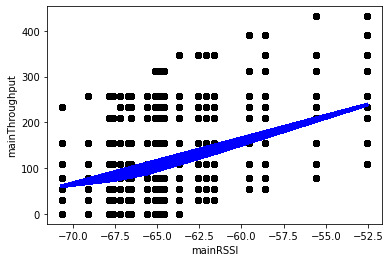

In [32]:
# Plot a line of best fit
plt.scatter(X_test, y_test, color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)
plt.xlabel('mainRSSI')
plt.ylabel('mainThroughput')
plt.show();

In [33]:
# Evaluate the model
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))

# Error rate of the model 
print('Error rate: %.2f' % (np.mean(y_pred != y_test)))

Mean squared error: 7498.06
Coefficient of determination: 0.27
Error rate: 1.00


# Submission

In [31]:
# Ensemble predictions
predictions = np.mean(predictions, axis = 0) 

# Create submission file
submission = pd.DataFrame({'ID': test['ID'], 'Target': predictions})
submission.to_csv('submission.csv', index = False)